In [270]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import xlrd
from scipy.integrate import ode
from scipy import integrate

## Initial Condition

In [55]:
# All in units of metric

HPSI=0.02524
temp_HPSI=32.22
Break_Area=0.01824
Break_Height=18.90
Cross_Area=6.503
RCS_temp=304.4
RCS_pressure=9142448
Water_V=287.7
Steam_V=50.97
hi=137000
qdot=64e6 #Assume 2% of 3200 MW


workbook = xlrd.open_workbook("C:/Users/Zhonghan/Desktop/nuclear_power_plant/Therm_Pressure_Table.xlsx")
Thermo_data=np.zeros([73,6])
for i in np.arange(73):
    for j in np.arange(6):
        Thermo_data[i,j]=workbook.sheet_by_index(1).cell_value(i+1,j)
        if j == 0 or j == 3 or j == 4:
            Thermo_data[i,j]= Thermo_data[i,j]*1000

## Variables of P

In [52]:
def vf(p=None): #returns vf, and slope at a pressure
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return ((Thermo_data[a,1]),(Thermo_data[a+1,1]-Thermo_data[a-1,1])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,1],(Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def vg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,2],(Thermo_data[a+1,2]-Thermo_data[a-1,2])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,2],(Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hf(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,3],(Thermo_data[a+1,3]-Thermo_data[a-1,3])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,3],(Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,4],(Thermo_data[a+1,4]-Thermo_data[a-1,4])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,4],(Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))
def mout_f(p=None):
    return(Break_Area*8300.54*(p/1378952)**0.71)
def mout_g(p=None):
    return(Break_Area*1953.0678*(p/1378952)**1.02)

Some unit conversion

$$\dot{m}_{out.f}=1700 \frac{lb}{s \cdot ft^2} \times \left(\frac{P}{200 psia}\right)^{0.71}= 1700 \frac{lb}{s \cdot ft^2} \left(\frac{0.4536 kg}{1lb}\right)\left(\frac{1 ft^2}{0.0929 m^2}\right) \times \left(\frac{P}{200 psia}\frac{1psia}{6894.76 pa}\right)^{0.71}$$ 
$$=8300.54 \frac{kg}{s \cdot m^2} \times \left(\frac{P}{1,378,952 pascal}\right)^{0.71}$$

In [203]:
def system_eq1( t=None,y=None):
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hf(y[0])[0]*mout_f(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_f(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI-mout_f(y[0])-(qdot/(hf(y[0])[0]-hi)),qdot/(hf(y[0])[0]-hi)]))

def system_eq2( t=None, y=None):
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hg(y[0])[0]*mout_g(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_g(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI-(qdot/(hg(y[0])[0]-hi)),qdot/(hg(y[0])[0]-hi)-mout_g(y[0])]))

y0=np.array([RCS_pressure, Water_V/(vf(RCS_pressure)[0]), Steam_V/(vg(RCS_pressure)[0])])

## Runge Kutta Integrator Method

In [208]:
Solver = ode(system_eq1).set_integrator("dopri5")
Solver.set_initial_value(y0,0)
t=0.1
i=1
val=Solver.integrate(t)

DATA1=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])

while DATA1[i,4] >  Break_Height: #62 ft
    t += 0.1
    i += 1
    val=Solver.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])


In [209]:
t_crit=t
i_crit=i

Solver2=ode(system_eq2).set_integrator("dopri5")
Solver2.set_initial_value(DATA1[i][1:4],t)
while DATA1[i,4] >  17.31: #56.79 ft
    t += 0.1
    i += 1
    val=Solver2.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])
    

In [217]:
DATA1

array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e-01,   9.14225418e+06,   2.02137587e+05,
          2.53617181e+03,   4.42270899e+01,   5.79961443e+02],
       [  2.00000000e-01,   9.14206034e+06,   2.02074403e+05,
          2.54136253e+03,   4.42130607e+01,   5.79952713e+02],
       ..., 
       [  2.45400000e+02,   5.86045175e+06,   8.56543882e+04,
          1.82977237e+03,   1.73125775e+01,   4.22943507e+02],
       [  2.45500000e+02,   5.85651669e+06,   8.56519747e+04,
          1.81660930e+03,   1.73103793e+01,   4.22741855e+02],
       [  2.45600000e+02,   5.85258101e+06,   8.56495612e+04,
          1.80345686e+03,   1.73081810e+01,   4.22540131e+02]])

## Euler Method

### Time Step = 10 sec

In [253]:
def Euler_Method(Table=None, dt=None):
    j=1

    Table=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
    val2 = Table[1:4]+system_eq1(0,Table[1:4])*dt
    layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
    Table=np.vstack([Table,layer])

    while Table[j,4] >  Break_Height: #62 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq1(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])

    j_crit=j

    while Table[j,4] >   17.31: #56.79 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq2(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])
    return(j_crit*dt, Table)

In [260]:
DATA2=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA2=Euler_Method(DATA2,10)
print(DATA2)

(190, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e+01,   9.12306648e+06,   1.95882256e+05,
          3.05004792e+03,   4.28387915e+01,   5.79096955e+02],
       [  2.00000000e+01,   9.10353454e+06,   1.89572112e+05,
          3.56947480e+03,   4.14394251e+01,   5.78216414e+02],
       [  3.00000000e+01,   9.08384635e+06,   1.83270410e+05,
          4.08926505e+03,   4.00430423e+01,   5.77328276e+02],
       [  4.00000000e+01,   9.06399580e+06,   1.76977222e+05,
          4.60942210e+03,   3.86496661e+01,   5.76432248e+02],
       [  5.00000000e+01,   9.04397638e+06,   1.70692625e+05,
          5.12994950e+03,   3.72593205e+01,   5.75528020e+02],
       [  6.00000000e+01,   9.02378121e+06,   1.64416696e+05,
          5.65085093e+03,   3.58720307e+01,   5.74615267e+02],
       [  7.00000000e+01,   9.00340298e+06,   1.58149516e+05,
          6.17213023e+03,   3.44878229e+01,   5.73693638e

### Time Step = 1 sec

In [258]:
DATA3=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA3=Euler_Method(DATA3,1)
print(DATA3)

(185, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e+00,   9.14050985e+06,   2.01568920e+05,
          2.58288780e+03,   4.41008291e+01,   5.79882875e+02],
       [  2.00000000e+00,   9.13857023e+06,   2.00937153e+05,
          2.63479808e+03,   4.39605682e+01,   5.79795506e+02],
       ..., 
       [  2.41000000e+02,   6.05700324e+06,   8.53973861e+04,
          2.50305730e+03,   1.73458087e+01,   4.32966532e+02],
       [  2.42000000e+02,   6.01203378e+06,   8.53732322e+04,
          2.36605867e+03,   1.73214203e+01,   4.30681768e+02],
       [  2.43000000e+02,   5.96708590e+06,   8.53490833e+04,
          2.23027560e+03,   1.72970533e+01,   4.28393143e+02]]))


### Time Step = 0.1sec

In [264]:
DATA4=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA4=Euler_Method(DATA4,0.1)
print(DATA4)

(184.4, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e-01,   9.14225418e+06,   2.02137587e+05,
          2.53617179e+03,   4.42270899e+01,   5.79961444e+02],
       [  2.00000000e-01,   9.14206036e+06,   2.02074403e+05,
          2.54136249e+03,   4.42130605e+01,   5.79952713e+02],
       ..., 
       [  2.45300000e+02,   5.86365780e+06,   8.56559333e+04,
          1.83935268e+03,   1.73142834e+01,   4.23107772e+02],
       [  2.45400000e+02,   5.85972329e+06,   8.56535197e+04,
          1.82617561e+03,   1.73120854e+01,   4.22906180e+02],
       [  2.45500000e+02,   5.85578815e+06,   8.56511062e+04,
          1.81300919e+03,   1.73098872e+01,   4.22704516e+02]]))


## Results

<IPython.core.display.Javascript object>


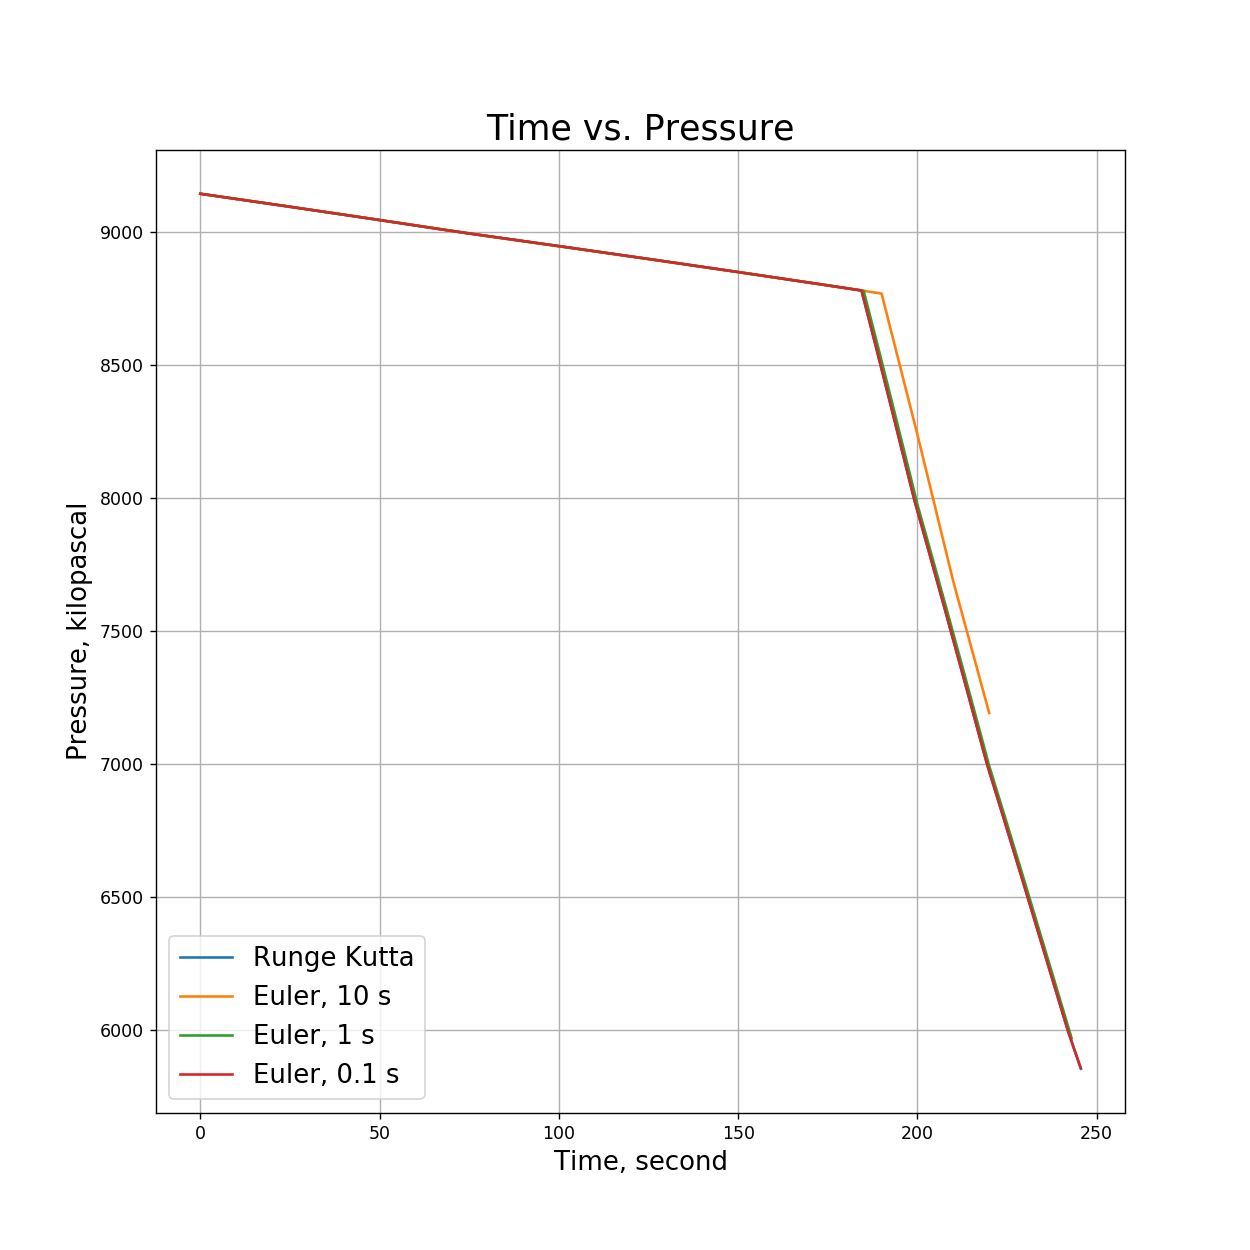

In [276]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Pressure", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Pressure, kilopascal", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,1]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,1]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,1]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,1]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


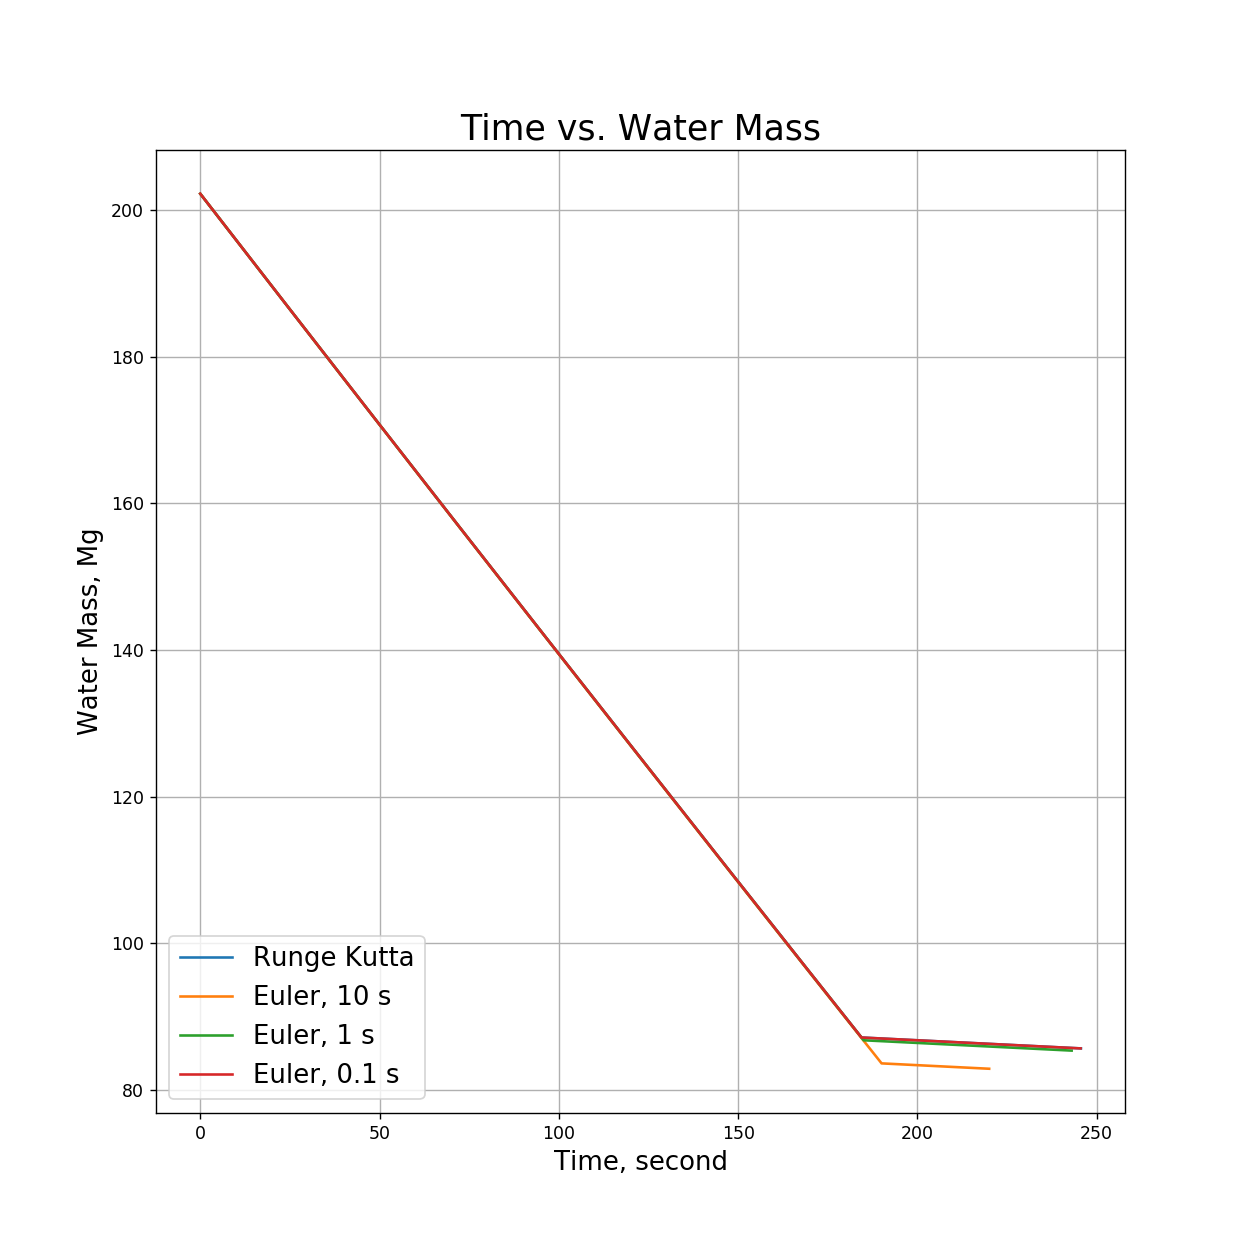

In [275]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,2]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,2]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,2]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,2]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


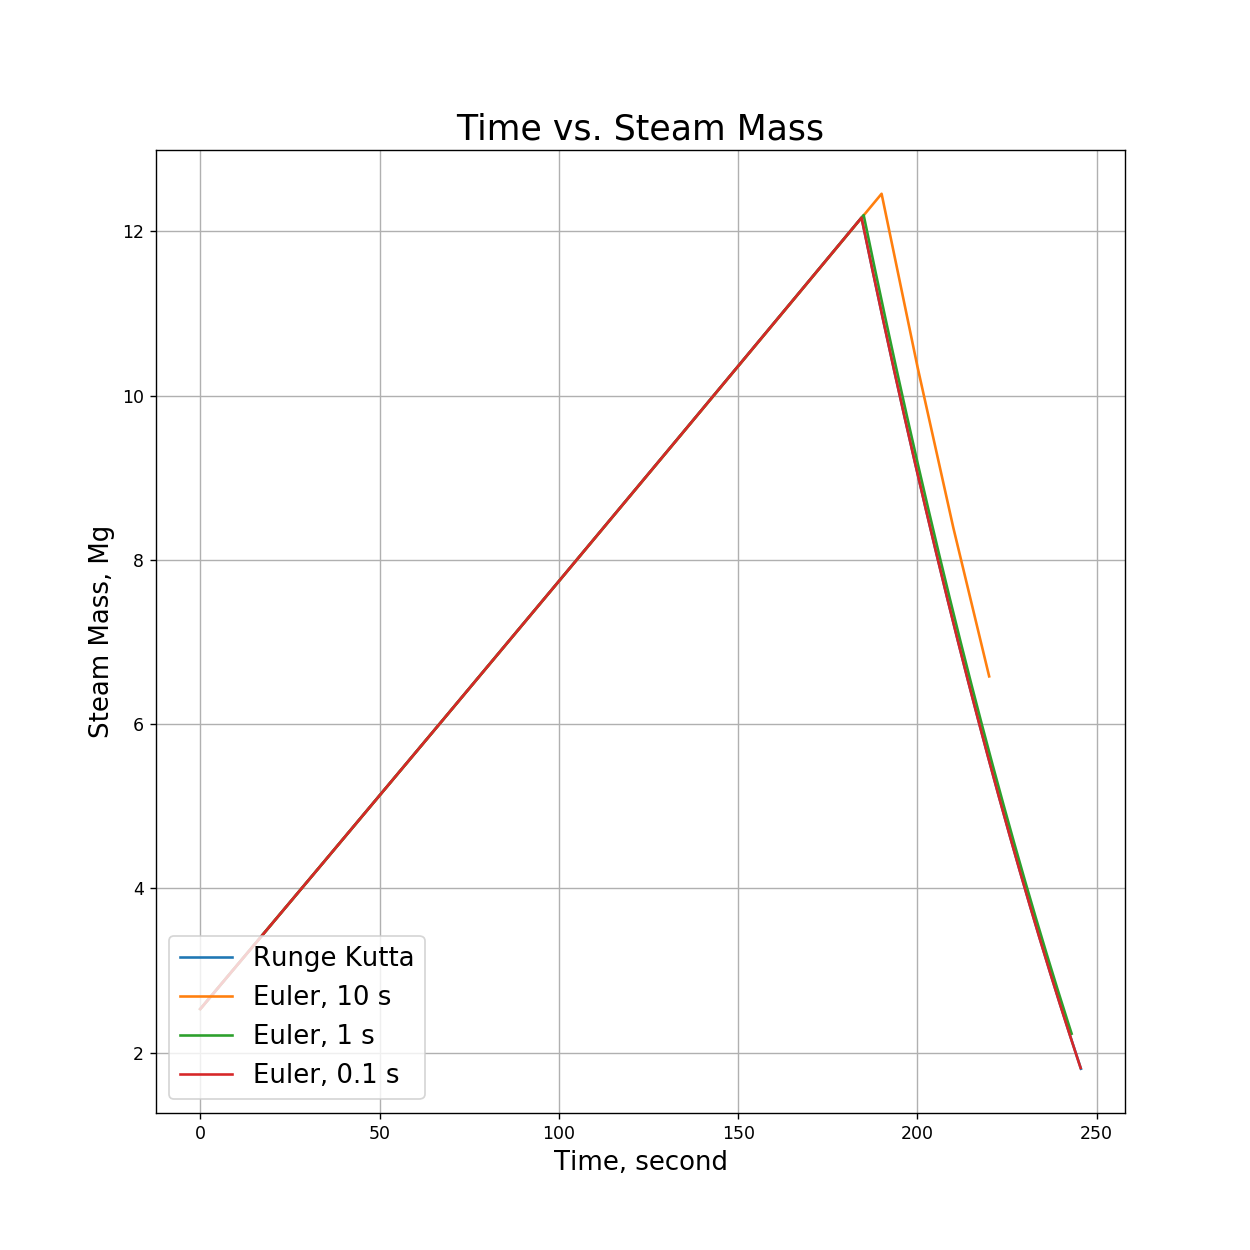

In [279]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Steam Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Steam Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,3]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,3]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,3]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,3]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


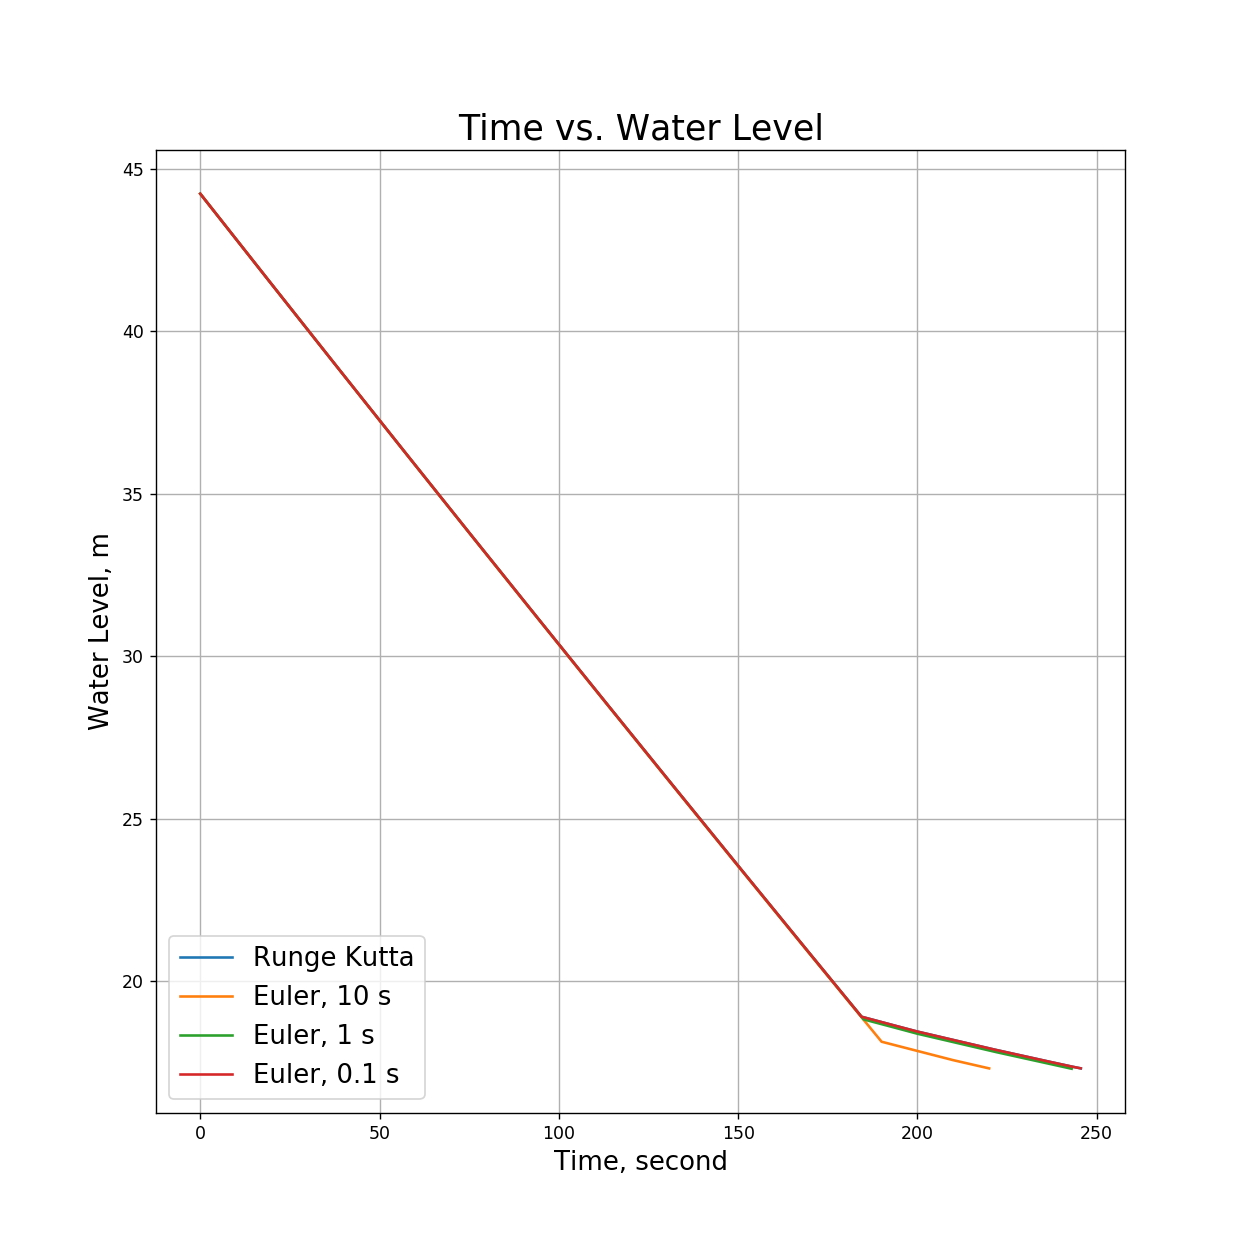

In [281]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Level", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Level, m", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,4], label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,4], label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,4], label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,4], label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()